In [1]:
!dir

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
import cv2
from scipy import signal

In [3]:
import CA_tasks_copy_deep

In [4]:
def np_show(arr):
    plt.axis('off')
    plt.set_cmap('inferno')
    plt.imshow(arr, interpolation='nearest')

In [5]:
def np_show_dubs(arr, visible):    
    plt.set_cmap('inferno')
    fig, axs = plt.subplots(1,2, figsize=(8, 4))
    axs[0].axis('off')
    axs[0].imshow(visible, interpolation='nearest')
    axs[1].axis('off')
    axs[1].imshow(arr, interpolation='nearest')

In [59]:
def np_show_dubs_many(arr, visible):    
    plt.set_cmap('inferno')
    fig, axs = plt.subplots(4,4, figsize=(16, 16))
    plt.subplots_adjust(hspace =0.02, wspace=0.02)
    for i in range(8):
        axs[i%4,2*(i//4)+0].axis('off')
        axs[i%4,2*(i//4)+0].imshow(arr[:,:,i], interpolation='nearest')
        axs[i%4,2*(i//4)+1].axis('off')
        axs[i%4,2*(i//4)+1].imshow(visible, interpolation='nearest')


In [7]:
sim = CA_tasks_copy_deep.CASimulator()
sim.cur_batch_size = 8
sim.load_pretrained(f'checkpoints/ca_model_mult_constant_pad.pt')

In [8]:
sim.initialize_states()
#sim.initialize_blank()
CA_tasks_copy_deep.reset_to_input(sim.input_matsA, sim.input_matsB, sim.current_states)

In [9]:
def step_sim(t_sim):
    with torch.no_grad():
        t_sim.sim_step()
        CA_tasks_copy_deep.reset_to_input(t_sim.input_matsA, t_sim.input_matsB, t_sim.current_states)


In [10]:
#step_sim(sim)
#CA_tasks_copy_deep.show_tensor_surfaces(sim.current_states)

In [11]:
all_states = []
vis_states = []
step_count = 120
for i in range(step_count):
    all_states.append(sim.current_states.cpu().permute(0,2,3,1).numpy()[:,:,:,1:25])
    vis_states.append(sim.current_states.cpu().permute(0,2,3,1).numpy()[:,:,:,0])
    step_sim(sim)
all_states = np.array(all_states)
vis_states = np.array(vis_states)
all_states.shape

(120, 8, 50, 50, 24)

In [12]:
all_states[6,0,0,0]

array([-0.07078784,  0.5146187 , -0.04282306, -0.03035215,  0.04190702,
        0.08382957,  0.00638111,  0.20792027,  0.27009267, -1.235407  ,
        0.07851584, -0.2326178 ,  0.06411322,  0.07205552, -0.26525992,
        0.02485564,  0.20295548, -0.09065747, -0.36678675,  0.02153584,
       -0.21918182, -0.18023628,  0.16092901, -0.07520579], dtype=float32)

In [13]:
all_states_flat = all_states.reshape(
    step_count*sim.cur_batch_size*sim.ENV_X*sim.ENV_Y,sim.ENV_D-1)
all_states_flat.shape

(2400000, 24)

In [14]:
pca = PCA(n_components=3)
pca.fit(all_states_flat)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
pca.explained_variance_ratio_

array([0.22406545, 0.21322604, 0.12907424])

In [16]:
pca.transform(all_states_flat)[0]

array([-1.667552 , -2.0002542,  0.7424117], dtype=float32)

In [17]:
def sig(x):
    return 1/(1+np.exp(-3*x))

In [18]:
def project(x,step_idx,batch):
    return pca.transform(x[step_idx,batch].reshape(50*50,24)).reshape(50,50,3)

In [19]:
#sig(project(all_states,shw_idx+1,0)-project(all_states,shw_idx,0))[:,:,0].shape

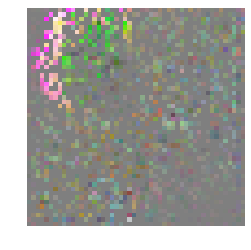

In [20]:
shw_idx = 42
np_show(sig(project(all_states,shw_idx+1,0)-project(all_states,shw_idx,0))[:,:,0:3])
#np_show(sig(project(all_states,shw_idx,0)))

In [21]:
all_states.shape

(120, 8, 50, 50, 24)

In [22]:
avgs = np.zeros_like(all_states[0,0])
all_avgs = []
for i in range(step_count-1):
    #np_show(sig(project(all_states,i+1,0)-project(all_states,i,0)))
    all_avgs.append(all_states[i+1,0,:,:,:]-avgs[:,:,:])
    avgs = 0.8*avgs + 0.2*(all_states[i,0]) # (sig(project(all_states,i+1,0)-project(all_states,i,0)))
    #np_show_dubs(avgs[:,:,0:3], vis_states[i,0,:,:])
    
    #np_show_dubs(sig(project(all_states,i,0))[:,:,0], vis_states[i,0,:,:])
    #np_show(all_states[i][0][:,:,0:3])
all_avgs = np.array(all_avgs)

In [23]:
all_avgs.shape

(119, 50, 50, 24)

In [24]:
avg_states_flat = all_avgs.reshape(
    (step_count-1)*sim.ENV_X*sim.ENV_Y,sim.ENV_D-1)
avg_states_flat.shape

(297500, 24)

In [25]:
avg_comps = 24
pca_avg = PCA(n_components=avg_comps)

pca_avg.fit(avg_states_flat)

PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [39]:
pca_avg.explained_variance_ratio_[0:8].sum()

0.7677498289538878

In [44]:
all_avgs[0,:,:,0].shape

(50, 50)

In [56]:
sobel_x = np.array([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])/8
sobel_y = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]])/8
for i in range(step_count-1):
    grad_x = signal.convolve2d(all_avgs[i,:,:,8], sobel_x, boundary='symm', mode='same')
    grad_y = signal.convolve2d(all_avgs[i,:,:,8], sobel_y, boundary='symm', mode='same')
    np_show(grad_x)
    
    plt.savefig(f'grads/test_all{i:06d}.png')
    plt.close('all')



In [27]:
def project_avg(x,step_idx):
    return pca_avg.transform(x[step_idx].reshape(50*50,24)).reshape(50,50,avg_comps)

In [61]:
for i in range(step_count-1):
    #np_show(sig(project(all_states,i+1,0)-project(all_states,i,0)))
    np_show_dubs_many(project_avg(all_avgs, i), vis_states[i,0,:,:])
    
    plt.savefig(f'test/test_all{i:06d}.png')
    plt.close('all')

In [35]:
avgs = np.zeros_like(all_states[0,0])
for i in range(step_count-1):
    #np_show(sig(project(all_states,i+1,0)-project(all_states,i,0)))
    np_show_dubs(all_states[i+1,0,:,:,0:3]-avgs[:,:,0:3], vis_states[i,0,:,:])
    avgs = 0.8*avgs + 0.2*(all_states[i,0]) # (sig(project(all_states,i+1,0)-project(all_states,i,0)))
    #np_show_dubs(avgs[:,:,0:3], vis_states[i,0,:,:])
    
    #np_show_dubs(sig(project(all_states,i,0))[:,:,0], vis_states[i,0,:,:])
    #np_show(all_states[i][0][:,:,0:3])
    plt.savefig(f'test/test_all{i:06d}.png')
    plt.close('all')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

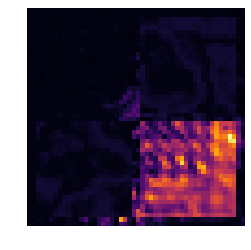

In [55]:
np_show(vis_states[45,0,:,:])

In [31]:
vis_states[100,0,:,:].mean()

0.16494085

In [281]:
frame_array = []
for i in range(step_count-1):
    frame_array.append(sig(project(all_states,i+1,0)-project(all_states,i,0)))

In [289]:
out = cv2.VideoWriter('testvid.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, (50,50))
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

In [182]:
all_states_flat[0]

array([ 0.01038061, -0.9144148 , -1.5347617 , -0.835726  ,  2.4939487 ,
        0.04377855, -0.32391125,  0.50523365,  1.8672578 , -0.69513124,
       -1.1496603 , -0.15411423, -0.09282257,  0.1411084 , -1.4276118 ,
       -0.3963426 , -0.32484937,  0.30321667, -0.3049798 , -0.34140334,
        1.1879368 ,  0.1712804 , -1.0978153 ,  0.23053381, -0.9306788 ],
      dtype=float32)

In [161]:
all_states[0,0,0,:]

array([[ 0.01038061, -0.9144148 , -1.5347617 , ..., -1.0978153 ,
         0.23053381, -0.9306788 ],
       [ 0.01176213, -1.0758302 , -1.4663072 , ..., -1.0217056 ,
        -0.23784524, -1.0294551 ],
       [ 0.01832818, -1.1123533 , -1.4610168 , ..., -0.6430209 ,
        -0.2562738 , -1.1599998 ],
       ...,
       [ 0.0278001 , -1.0576501 , -2.2815719 , ..., -1.2945544 ,
        -1.3197156 , -0.8643807 ],
       [ 0.03133264, -1.2666701 , -1.8494084 , ..., -0.63813835,
        -0.1895038 , -1.2840605 ],
       [-0.01120403, -0.99299663, -0.7378058 , ..., -0.6038075 ,
         0.09521035, -0.51718175]], dtype=float32)

In [95]:
all_states[0,0,:,:,0:3].shape

(50, 50, 3)

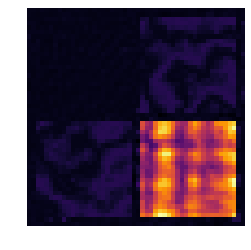

In [64]:
np_show(vis_states[46,0,:,:])

In [29]:
def basic_show(t):
    plt.axis('off')
    plt.set_cmap('inferno')
    plt.imshow(t.permute(1,2,0).cpu().detach(), interpolation='nearest')

In [30]:
sim.current_states.shape

torch.Size([8, 25, 50, 50])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


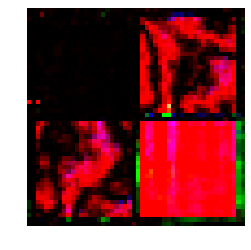

In [98]:
step_sim(sim)
basic_show(sim.current_states[0,0:3,:,:])

In [35]:
sim.current_states[0,0:3,:,:].shape

torch.Size([3, 50, 50])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


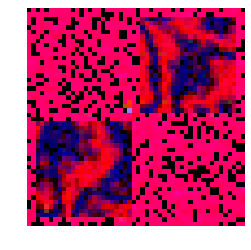

In [34]:
basic_show(sim.current_states[0,0:3,:,:])